# **ENDG 511 Lab 2 Assignment: Model Pruning and Quantization**

This colab notebook provides code and a framework for ***Lab 3***. You can work out your solutions here.


## Goals

In this lab, you will be introduced to different model optimization methods using TensorFlow and Keras, and you will learn how to use them to create efficient deep learning models. The goals of this lab are:

- Understand the basics of pruning and quantization.
- Apply pruning and quantization to an MNIST model.
- Understand and use TFLite.
- Evaluate models in terms of accuracy, size and inference time.
- Understand how different pruning and quantization parameters can impact accuracy, size and inference time.
- Apply collaborative optimization by combining pruning and quantization.

## Layout
This lab is split into **three** parts.
- **Part 1**: Apply pruning to an MNIST model and evaluate the pruned model.
- **Part 2**: Apply post-training quantization and evaluate the quantized model.
- **Part 3**: Combine pruning and post-training quantization and evaluate the final model.

## How to submit the Assignment

- You are required to sumbmit the completed python notebook and a **pdf version** of it in a Dropbox folder on D2L.
- This is an individual assignment, and all the assignements must be submitted individually.
- This assignment can be completed directly on Google Colab, but you are free to choose any other computing resource.
-  Lab sessions will be held to go over the main concepts and help you with the assignment.


# **Part 1**: Pruning

This part of the lab demonstrates applying pruning to a neural network to reduce size and inference while maintaining a similar accuracy to the original neural network. At a high level, the steps required to prune and evaluate a model are as follows:

- Build and train the dense baseline
- Prune model
- Fine-tune pruned model
- Evaluate the model

There are different types of pruning techniques, the technique demonstrated in this lab is magnitude-based weight pruning (also referred to as unstructured pruning). Magnitude-based weight pruning gradually zeroes out model weights based on their importance during the training process to achieve model sparsity. Sparse models are easier to compress, and we can skip the zeroes during inference for latency improvements. The image below can help you visualize pruning:

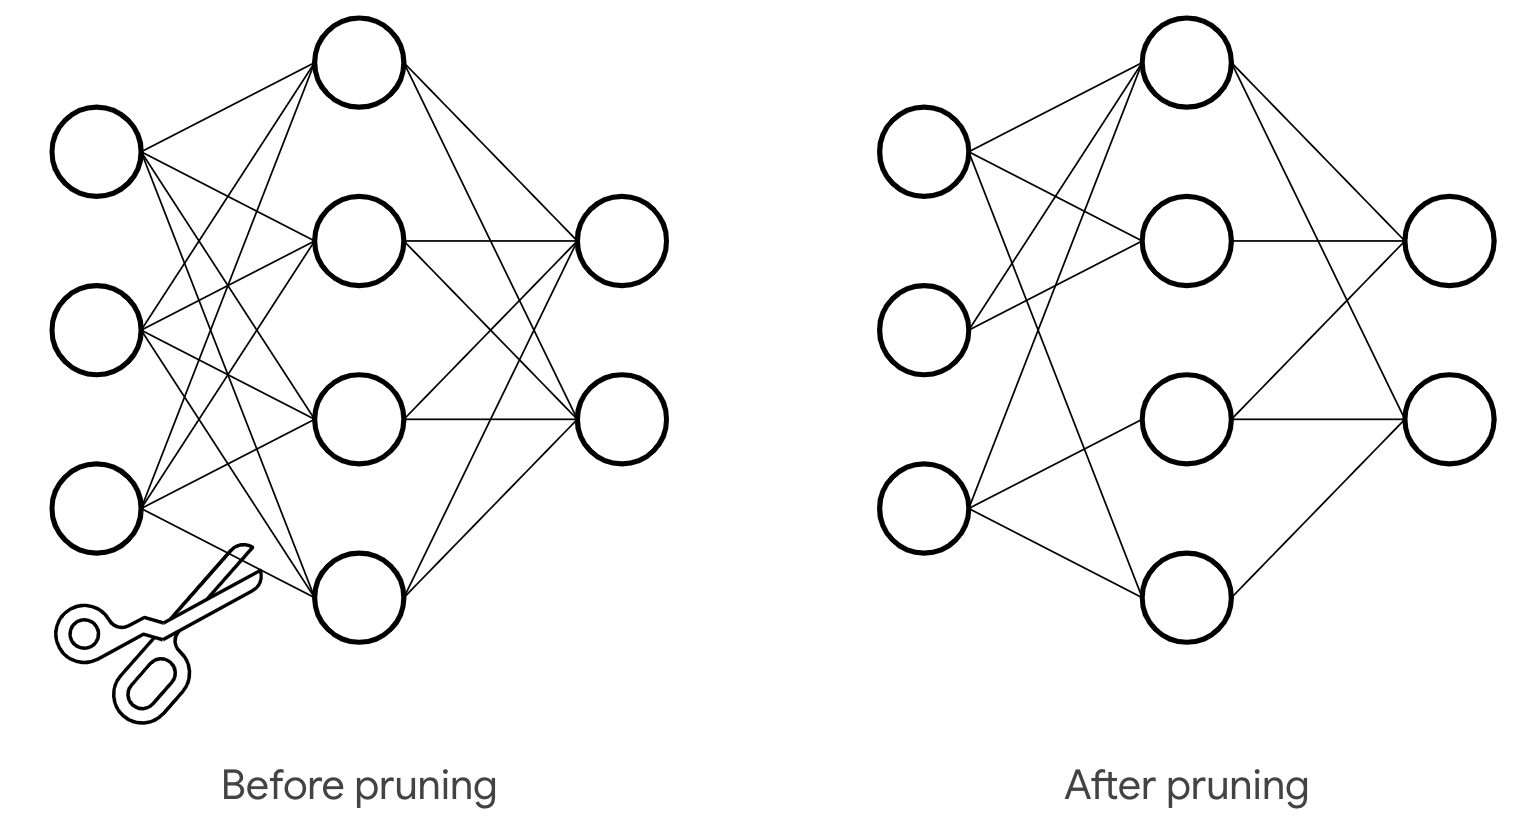

### Import and install all required modules

In [3]:
!pip install -q tensorflow-model-optimization

import tempfile
import os
import time

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_model_optimization as tfmot


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Build and Train a neural network for MNIST without pruning

Similar to the examples presented in Lab1 we will build and train a neural network for the MNIST dataset without any model optimization. This will be our base model for the remainder of this lab. We also save the model before training.


In [4]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture.
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

# Save untrained model
model.save('untrained_base_model.h5')

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_split=0.1,
)

Let's display the architecture of our model:

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Save model
Let us save the trained model so that we can evaluate at a later stage.

In [4]:
# Save your trained model
model.save('trained_base_model.h5')

### Prune the dense model
We will create a pruned model from our original model. We will force the model to have 50% sparsity (50% of the weights are zeroed out). Finally we recompile our new pruned model.

Note: ConstantSparsity performs "one-shot" magnitude based pruning of all the layers. There are more advanced techniques but this is the simplest one. The total number of parameters increases because tensorflow adds a "pruning wrapper" to all parameters, this gets stripped at a later stage.

In [5]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
## Print weights before and after

# Define model for pruning. The 0.5 is the target sparsity (50%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
}

pruned_model = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
pruned_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

### Fine-tune pruned model
Next, we have to fine-tune our pruned model by retraining for a suitable number of epochs.
Note: tfmot.sparsity.keras.UpdatePruningStep is required as a callback during training.

In [6]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_model.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)

Epoch 1/2
1688/1688 [==============================] - 9s 4ms/step - loss: 0.0707 - accuracy: 0.9774 - val_loss: 0.0679 - val_accuracy: 0.9800
Epoch 2/2
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0606 - accuracy: 0.9806 - val_loss: 0.0665 - val_accuracy: 0.9797


### Apply strip pruning

strip_pruning is necessary since it removes every tf.Variable that pruning only needs during training, which would otherwise add to the final model size. It strips the pruning wrapper, It is also needed when converting to a TFLite model.

In [7]:
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
stripped_pruned_model.save('stripped_pruned_model.h5')

### Confirm that pruning was correctly applied

In [5]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )
print_model_weights_sparsity(stripped_pruned_model)

### Evaluate the model
Finally, we compare the pruned model to the base model. We can see that the accuracy and inference time is comparable, however, the pruned model is much smaller in size.

Note: Pruning is capable of improving inference time significantly, however, additional libraries and modifications are needed to see inference improvements as a result of pruning (Pruning inference improvements is very hardware specific!). If you are curious you can read this paper which explains how sparse models can be used to accelerate inference (https://arxiv.org/pdf/1911.09723.pdf)

In [11]:
# Evaluate prediction accuracy
model = tf.keras.models.load_model('trained_base_model.h5')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
test_loss_pruned_50, test_acc_pruned_50 = pruned_model.evaluate(test_images,  test_labels, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_model.predict(test_images)
executionTimePruned50 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_base_model.h5')
## Print without stripping
pruned_model_size = get_gzipped_model_size('stripped_pruned_model.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

print('\nPruned Model Accuracy:', test_acc_pruned_50*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size))
print("Pruned Inference Time is", executionTimePruned50, "s")

### Excercies: (1.5 points)


Question 1: Load the trained base model (unpruned). Prune the model with a target sparsity of 90%. Evaluate the model in terms of accuracy, model size and inference time. **(0.5 points)**

In [10]:
model = tf.keras.models.load_model('trained_base_model.h5')

"""Prune the dense model"""
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
## Print weights before and after

# Define model for pruning. The 0.9 is the target sparsity (90%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.9, begin_step=0, frequency=100)
}

pruned_90_model = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
pruned_90_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_90_model.summary()

"""Fine tune pruned model."""
print("Fine tuning pruned model...")
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_90_model.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)

"""Apply strip pruning"""
stripped_pruned_90_model = tfmot.sparsity.keras.strip_pruning(pruned_90_model)
stripped_pruned_90_model.save('stripped_90_pruned_model.h5')

"""Confirming pruning being applied correctly."""
print("Checking pruning application...")
print_model_weights_sparsity(stripped_pruned_90_model)

"""Model Evaluation"""
print("Evaluating pruned model...")
test_loss_pruned_90, test_acc_pruned_90 = pruned_90_model.evaluate(test_images,  test_labels, verbose=0)

startTime = time.time()
prediction = pruned_90_model.predict(test_images)
executionTimePruned90 = (time.time() - startTime)/len(test_images)

pruned_model_size = get_gzipped_model_size('stripped_90_pruned_model.h5')
print('\nPruned Model Accuracy:', test_acc_pruned_90*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size))
print("Pruned Inference Time is", executionTimePruned90, "s")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 2ms/step

Pruned Model Accuracy: 95.3499972820282 %
Pruned Model Size: 80123.00 bytes
Pruned Inference Time is 9.749836921691894e-05 s


### Observation
A model pruned at 90% shows a decrease in accuracy of ~2-3% in comparison to the 
base model. There is ~80% reduction in model size when the model is pruned at
90%. Furthermore, the model pruned at 90% is ~1.5us faster than the unpruned model.
However, it is ~0.6ms slower than the model pruned at 50%. 

Question 2: Load the trained base model (unpruned). Prune the model with a target sparsity of 10%. Evaluate the model in terms of accuracy, model size and inference time. **(0.5 points)**

In [11]:
model = tf.keras.models.load_model('trained_base_model.h5')

"""Prune the dense model"""
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
## Print weights before and after

# Define model for pruning. The 0.1 is the target sparsity (10%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.1, begin_step=0, frequency=100)
}

pruned_10_model = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
pruned_10_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_10_model.summary()

"""Fine tune pruned model."""
print("Fine tuning pruned model...")
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_10_model.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)

"""Apply strip pruning"""
stripped_pruned_10_model = tfmot.sparsity.keras.strip_pruning(pruned_10_model)
stripped_pruned_10_model.save('stripped_10_pruned_model.h5')

"""Confirming pruning being applied correctly."""
print("Checking pruning application...")
print_model_weights_sparsity(stripped_pruned_10_model)

"""Model Evaluation"""
print("Evaluating pruned model...")
test_loss_pruned_10, test_acc_pruned_10 = pruned_10_model.evaluate(test_images,  test_labels, verbose=0)

startTime = time.time()
prediction = pruned_10_model.predict(test_images)
executionTimePruned10 = (time.time() - startTime)/len(test_images)

pruned_model_size = get_gzipped_model_size('stripped_10_pruned_model.h5')
print('\nPruned Model Accuracy:', test_acc_pruned_10*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size))
print("Pruned Inference Time is", executionTimePruned10, "s")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

### Observation
A model pruned at 10% shows an increase in accuracy of ~0.2-0.3% in comparison to the 
base model. There is only ~0.4% reduction in model size when the model is pruned at
10%. Furthermore, the model pruned at 10% is ~4.1us slower than the unpruned model.

Question 3: Plot a bar graph to show how each metric varies at a different sparsity %ages of 0%, 10%, 30%, 50%, 70%, and 90% (3 graphs in total). **(0.5 points)**

In [3]:
from typing import Tuple
def prune_model(
        base_model: str="trained_base_model.h5",
        target_sparsity: float=0.50,
        verbose: bool=False,
        new_model: str="new_stripped_pruned_model.h5"
        ) -> Tuple[float, float, float]:
    """
    This function prunes the base model fine tunes the model.

    Parameters
    ----------
        base_model: str
            The path to the base model.

        target_sparsity: float
            The model target sparsity or the pruning percentage.

        verbose: bool
            Print the model summary and the metrics.

        new_model: str
            This is the path to save the pruned model.

    Returns
    -------
        test_acc_pruned: float
            The accuracy of the model as a percent.
        
        pruned_model_size: float
            The size of the pruned model in bytes 
            
        executionTimePruned: float
            The inference time of the pruned model in seconds.
    """
    model = tf.keras.models.load_model(base_model)

    """Prune the dense model"""
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    ## Print weights before and after
    # Define model for pruning. 
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(
            target_sparsity, begin_step=0, frequency=100)
    }
    pruned_model = prune_low_magnitude(model, **pruning_params)

    # `prune_low_magnitude` requires a recompile.
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    pruned_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    """Fine tune pruned model."""
    if verbose:
        pruned_model.summary()
        print("Fine tuning pruned model...")

    callbacks = [tfmot.sparsity.keras.UpdatePruningStep(),]
    pruned_model.fit(
        train_images, 
        train_labels, 
        epochs=2, 
        validation_split=0.1,
        callbacks=callbacks)

    """Apply strip pruning"""
    stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
    stripped_pruned_model.save(new_model)

    """Confirming pruning being applied correctly."""
    if verbose:
        print("Checking pruning application...")
        print_model_weights_sparsity(stripped_pruned_model)
        print("Evaluating pruned model...")

    """Model Evaluation"""
    test_loss_pruned, test_acc_pruned = pruned_model.evaluate(
        test_images, test_labels, verbose=0)

    startTime = time.time()
    prediction = pruned_model.predict(test_images)
    executionTimePruned = (time.time() - startTime)/len(test_images)
    pruned_model_size = get_gzipped_model_size(new_model)

    if verbose:
        print('\nPruned Model Accuracy:', test_acc_pruned*100, '%')
        print("Pruned Model Size: %.2f bytes" % (pruned_model_size))
        print("Pruned Inference Time is", executionTimePruned, "s")

    return test_acc_pruned*100, pruned_model_size, executionTimePruned

In [8]:
"""Gather Data Plots"""
target_sparsities = [0., 0.10, 0.30, 0.50, 0.70, 0.90]
accuracies = list()
model_sizes = list()
inference_times = list()

for target_sparsity in target_sparsities:
    accuracy, model_size, inference_time = prune_model(target_sparsity=target_sparsity)
    accuracies.append(accuracy)
    model_sizes.append(model_size)
    inference_times.append(inference_time)

print(f"{accuracies=}")
print(f"{model_sizes=}")
print(f"{inference_times=}")

Epoch 1/2
1688/1688 [==============================] - 10s 5ms/step - loss: 0.0678 - accuracy: 0.9783 - val_loss: 0.0743 - val_accuracy: 0.9790
Epoch 2/2
313/313 [==============================] - 4s 10ms/step
Epoch 1/2
1688/1688 [==============================] - 13s 4ms/step - loss: 0.0659 - accuracy: 0.9792 - val_loss: 0.0746 - val_accuracy: 0.9792
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 12s 6ms/step - loss: 0.0650 - accuracy: 0.9787 - val_loss: 0.0683 - val_accuracy: 0.9805
Epoch 2/2
313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 14s 6ms/step - loss: 0.0708 - accuracy: 0.9777 - val_loss: 0.0678 - val_accuracy: 0.9795
Epoch 2/2
313/313 [==============================] - 1s 3ms/step
Epoch 1/2
1688/1688 [==============================] - 12s 6ms/step - loss: 0.1015 - accuracy: 0.9695 - val_loss: 0.0687 - val_accuracy: 0.9770
Epoch 2/2
313/313 [

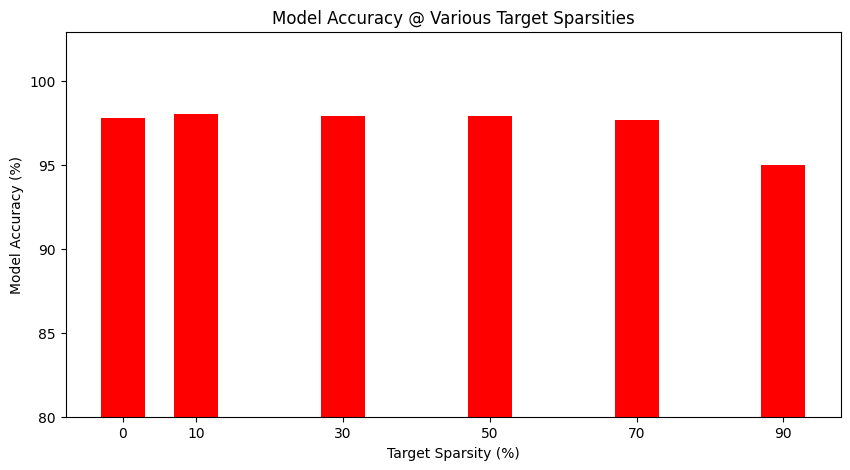

In [22]:
"""Accuracy Metric"""
sparsitys = [sparsity*100 for sparsity in target_sparsities]
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(sparsitys, accuracies, color ='red', width = 6.0)
plt.xlabel("Target Sparsity (%)")
plt.ylabel("Model Accuracy (%)")
plt.xticks(sparsitys)
plt.ylim(80)
plt.title("Model Accuracy @ Various Target Sparsities")
plt.show()

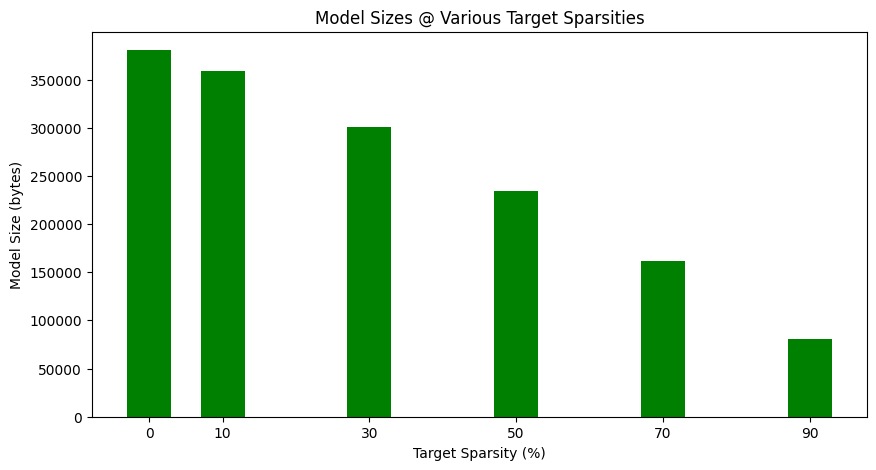

In [23]:
"""Model Size"""
sparsitys = [sparsity*100 for sparsity in target_sparsities]
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(sparsitys, model_sizes, color ='green', width = 6.0)
plt.xlabel("Target Sparsity (%)")
plt.ylabel("Model Size (bytes)")
plt.xticks(sparsitys)
plt.title("Model Sizes @ Various Target Sparsities")
plt.show()

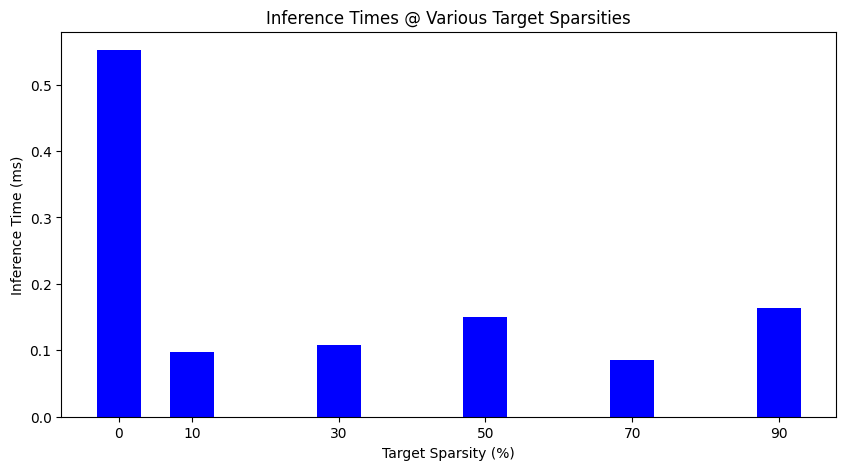

In [25]:
"""Inference Time"""
sparsitys = [sparsity*100 for sparsity in target_sparsities]
times = [t*1000 for t in inference_times]
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(sparsitys, times, color ='blue', width=6.0)
plt.xlabel("Target Sparsity (%)")
plt.ylabel("Inference Time (ms)")
plt.xticks(sparsitys)
plt.title("Inference Times @ Various Target Sparsities")
plt.show()

# **Part 2**:  Quantization
This part of the lab demonstrates applying quantization to a neural network to reduce size and inference while maintaining a similar accuracy to the original neural network. At a high level, the steps required to quantize and evaluate a model are as follows:

- Build and train the dense baseline
- Apply quantization during conversion to TFLite
- Evaluate the model

There are different quantization techniques, the technique demonstrated in this lab is post-training quantization. The main idea behind quantization is that the weights and activations can be converted to types with reduced precision, such as 16 bit floats or 8 bit integers instead of 32 bit floats which can signficantly reduce model size and inference with minimal accuracy tradeoffs.

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

A TensorFlow Lite model is represented in a special efficient portable format known as FlatBuffers (identified by the .tflite file extension). This provides several advantages over TensorFlow's protocol buffer model format such as reduced size (small code footprint) and faster inference (data is directly accessed without an extra parsing/unpacking step) that enables TensorFlow Lite to execute efficiently on devices with limited compute and memory resources.
You can find more information here: https://www.tensorflow.org/lite/guide

### Load base model
Firstly, let us load the base model we have trained earlier.

In [26]:
model_to_quantize = tf.keras.models.load_model('trained_base_model.h5')
model_to_quantize.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Convert to TFLite and apply quantization
The next step is converting the base model to a TFLite model and applying quantization through the different APIs that TFLite provides. In this example we are using 8-bit quantization, this is done by using the DEFAULT optimizer. The commented codes provide an example of how to apply 16-bit floating point quantization.

In [27]:
# Passing the Keras model to the TFLite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
# Setting the deault optimizer
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# To convert to 16-bit floating point for example
# converter.target_spec.supported_types = [tf.float16]
# Convert the model
quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp73fnnmfx\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp73fnnmfx\assets


### Save TFLite model and load model into an interpeter
Firstly we save the TFLite model, this will allow us to load it into an interpreter. To perform an inference with a TensorFlow Lite model, you must run it through an interpreter. The TensorFlow Lite interpreter is designed to be lean and fast.
You can find more information on the TFLite interpeter here: https://www.tensorflow.org/lite/guide/inference

In [28]:
# Save TFLite Model
with open('quantized_tflite_model.tflite', 'wb') as f:
  f.write(quantized_tflite_model)
# Load model into interpeter
interpreter_quant = tf.lite.Interpreter(model_path=str('quantized_tflite_model.tflite'))
interpreter_quant.allocate_tensors()

### Evaluate the model
Finally, we evaluate the quantized model in terms of accuracy, inference time and model size.

In [16]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter, model_path, verbose=True):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    startTime = time.time()
    interpreter.invoke()
    executionTime = (time.time() - startTime)/len(test_images)

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  model_size = get_gzipped_model_size(model_path)
  if verbose:
    # Print
    print('\nModel Accuracy:', accuracy*100, '%')
    print("Model Size: %.2f bytes" % (model_size))
    print("Inference Time is", executionTime, "s")
  return accuracy, model_size, executionTime

evaluate_model(interpreter_quant, 'quantized_tflite_model.tflite')

### Exercise (0.5 points)

Question 1: Load the base model and apply 16 bit floating point quantization. Use the TFLite interpeter to evaluate your model. **(0.5 points)**

In [30]:
model_to_quantize = tf.keras.models.load_model('trained_base_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
fp16_quantized_tflite_model = converter.convert()

with open('fp16_quantized_tflite_model.tflite', 'wb') as f:
  f.write(fp16_quantized_tflite_model)
interpreter_fp16_quant = tf.lite.Interpreter(model_path=str('fp16_quantized_tflite_model.tflite'))
interpreter_fp16_quant.allocate_tensors()

evaluate_model(interpreter_fp16_quant, 'fp16_quantized_tflite_model.tflite')

INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp1visy8_a\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp1visy8_a\assets



Model Accuracy: 97.52 %
Model Size: 189988.00 bytes
Inference Time is 0.0 s


(0.9752, 189988, 0.0)

# Part 3: Collaborative Optimization



### Exercise
Question 1 (2 points): Using the knowledge from part 1 and part 2, jointly apply pruning and post-training quantization to the base MNIST model.

Try the following combinations and plot 3 graphs (one for each metric of accuracy, model size , and inference time):

- no pruning, no quantization
- no pruning, fp16 quantization
- no pruning, 8-bit quantization

- 10% sparsity, no quantization
- 10% sparsity, fp16 quantization
- 10% sparsity, 8-bit quantization

- 50% sparsity, no quantization
- 50% sparsity, fp16 quantization
- 50% sparsity, 8-bit quantization

- 90% sparsity, no quantization
- 90% sparsity, fp16 quantization
- 90% sparsity, 8-bit quantization

To do this, write a prune_and_quantize function and loop over different sparsities and then append all the results into 3 different arrays (one for each metric).

For example the function definition could look like this:

**def prune_and_quantize(model, target_sparsity, fp16: bool, path_to_save)**

Hint: Below is an example of how you can graph your results using matplotlib
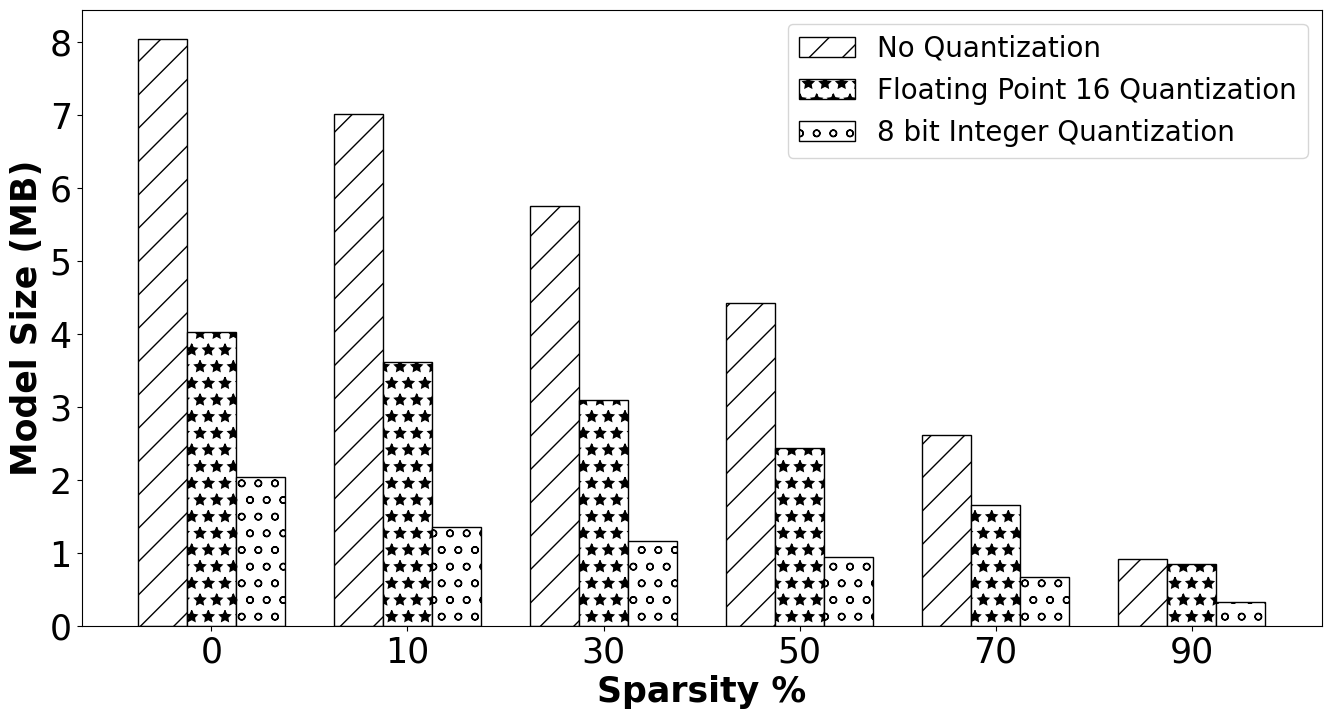

In [14]:
from typing import Tuple

def evaluate_mod(
        base_model: str,
        verbose: bool=False
    ) -> Tuple[float, float, float]:
    model = tf.keras.models.load_model(base_model)
    test_loss, test_acc = model.evaluate(
        test_images, test_labels, verbose=0)

    startTime = time.time()
    prediction = model.predict(test_images)
    executionTime = (time.time() - startTime)/len(test_images)
    model_size = get_gzipped_model_size(base_model)

    if verbose:
        print('\nPruned Model Accuracy:', test_acc*100, '%')
        print("Pruned Model Size: %.2f bytes" % (model_size))
        print("Pruned Inference Time is", executionTime, "s")
    return test_acc, model_size, executionTime

def quantize(
    base_model: str="trained_base_model.h5",
    fp16: bool=False,
    new_model: str="quantized_tflite_model.tflite",
    verbose: bool = False
) -> Tuple[float, float, float]:
    """
    This function quantizes the model either as a fp16 or 8-bit quantization.

    Parameters
    ----------
        model: str
            The path to the base model.

        fp16: bool
            This is to specify whether to perform 
            floating point quantization.

        new_model: str
            This is the path to save the pruned model.

        verbose: bool
            Print the model summary and the metrics.

    Return
    ------
        test_acc_quantized: float
            The accuracy of the quantized model.
        
        quantize_model_size: float
            The size of the quantized model in bytes 
            
        executionTimeQuantized: float
            The inference time of the quantized model in seconds.
    """
    model_to_quantize = tf.keras.models.load_model(base_model)
    if verbose:
        model_to_quantize.summary()
        print("Converting and quantizing model to tflite...")

    # Passing the Keras model to the TFLite Converter.
    converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
    # Setting the deault optimizer
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    # To convert to 16-bit floating point for example
    if fp16:
        converter.target_spec.supported_types = [tf.float16]
        
    # Convert the model
    quantized_tflite_model = converter.convert()

    # Save TFLite Model
    with open(new_model, 'wb') as f:
        f.write(quantized_tflite_model)
    # Load model into interpeter
    interpreter_quant = tf.lite.Interpreter(model_path=str(new_model))
    interpreter_quant.allocate_tensors()
    return evaluate_model(interpreter_quant, new_model, verbose)

def prune(
        base_model: str="trained_base_model.h5",
        target_sparsity: float=0.50,
        new_model: str="new_stripped_pruned_model.h5",
        verbose: bool=False,
        ) -> Tuple[float, float, float]:
    """
    This function prunes the base model.

    Parameters
    ----------
        model: str
            The path to the base model.

        target_sparsity: float
            The model target sparsity or the pruning percentage.

        new_model: str
            This is the path to save the pruned model.

        verbose: bool
            Print the model summary and the metrics.

    Returns
    -------
        test_acc_pruned: float
            The accuracy of the pruned model.
        
        pruned_model_size: float
            The size of the pruned model in bytes 
            
        executionTimePruned: float
            The inference time of the pruned model in seconds.
    """
    model = tf.keras.models.load_model(base_model)

    """Prune the dense model"""
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    ## Print weights before and after
    # Define model for pruning. 
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(
            target_sparsity, begin_step=0, frequency=100)
    }
    pruned_model = prune_low_magnitude(model, **pruning_params)

    # `prune_low_magnitude` requires a recompile.
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    pruned_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    """Fine tune pruned model."""
    if verbose:
        pruned_model.summary()
        print("Fine tuning pruned model...")

    callbacks = [tfmot.sparsity.keras.UpdatePruningStep(),]
    pruned_model.fit(
        train_images, 
        train_labels, 
        epochs=2, 
        validation_split=0.1,
        callbacks=callbacks)

    """Apply strip pruning"""
    stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
    stripped_pruned_model.save(new_model)

    """Confirming pruning being applied correctly."""
    if verbose:
        print("Checking pruning application...")
        print_model_weights_sparsity(stripped_pruned_model)
        print("Evaluating pruned model...")

    """Model Evaluation"""
    test_loss_pruned, test_acc_pruned = pruned_model.evaluate(
        test_images, test_labels, verbose=0)

    startTime = time.time()
    prediction = pruned_model.predict(test_images)
    executionTimePruned = (time.time() - startTime)/len(test_images)
    pruned_model_size = get_gzipped_model_size(new_model)

    if verbose:
        print('\nPruned Model Accuracy:', test_acc_pruned*100, '%')
        print("Pruned Model Size: %.2f bytes" % (pruned_model_size))
        print("Pruned Inference Time is", executionTimePruned, "s")

    return test_acc_pruned, pruned_model_size, executionTimePruned

def prune_and_quantize(
        model: str="trained_base_model.h5", 
        target_sparsity: float=0.50, 
        fp16: bool=False, 
        path_to_save: str="quantized_tflite_model.tflite",
        prun: bool=True,
        quantiz: bool=True,
        verbose: bool=False,
    ) -> Tuple[float, float, float]:
    """
    This function prunes and quantizes models.

    Parameters
    ----------
        model: str
            The path to the base model.

        target_sparsity: float
            The model target sparsity or the pruning percentage.

        fp16: bool
            Specify to perform float16 quantization.

        path_to_save: str
            This is the path to save the quantized model.

        prun: bool
            Specify to perform pruning.

        quantiz: bool
            Specify to perform quantization.

        verbose: bool
            Print the model summary and the metrics.

    Return
    ------
        test_acc: float
            The accuracy of the model.
        
        model_size: float
            The size of the model in bytes 
            
        executionTime: float
            The inference time of the model in seconds.
    """

    """Only prune and only quantize is meaningless"""
    if not prun and not quantiz:
        return evaluate_mod(model)

    pruned_model_path = None
    if prun:
        pruned_model_path = "pruned_model.h5"
        test_acc_pruned, pruned_model_size, executionTimePruned = prune(
            base_model=model,
            target_sparsity=target_sparsity,
            new_model=pruned_model_path,
            verbose=verbose,
        )

    if quantiz:
        # If a pruned model exists, use the pruned model.
        if pruned_model_path is not None:
            base_model = pruned_model_path
        else:
            base_model = model

        test_acc_quantized, quantize_model_size, executionTimeQuantized = quantize(
            base_model=base_model,
            fp16=fp16,
            new_model=path_to_save,
            verbose=verbose
        )
        return test_acc_quantized, quantize_model_size, executionTimeQuantized
    return test_acc_pruned, pruned_model_size, executionTimePruned

In [17]:
sparsities = [0,0.10,0.50,0.90]
quantizations = [0, 16, 8]

accuracies = list()
model_sizes = list()
inference_times = list()

do_prune = True
do_quantize = True
fp16=True

for sparsity in sparsities:
    if sparsity == 0:
        do_prune = False
        
    for quantization in quantizations:
        if quantization == 0:
            do_quantize = False
        elif quantization == 16:
            fp16 = True
        else:
            fp16 = False

        accuracy, model_size, inference_time = prune_and_quantize(
            target_sparsity=sparsity,
            prun=do_prune,
            quantiz=do_quantize,
        )
        accuracies.append(accuracy)
        model_sizes.append(model_size)
        inference_times.append(inference_time) 
        do_quantize = True
    do_prune = True

print(f"{accuracies=}")
print(f"{model_sizes=}")
print(f"{inference_times=}")

313/313 [==============================] - 1s 2ms/step
INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp2854y83h\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp2854y83h\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp5x39osaz\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp5x39osaz\assets


Epoch 1/2



1688/1688 [==============================] - 9s 4ms/step - loss: 0.0646 - accuracy: 0.9796 - val_loss: 0.0714 - val_accuracy: 0.9807
Epoch 2/2
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0575 - accuracy: 0.9814 - val_loss: 0.0660 - val_accuracy: 0.9810


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 8s 4ms/step - loss: 0.0664 - accuracy: 0.9799 - val_loss: 0.0759 - val_accuracy: 0.9797
Epoch 2/2
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0572 - accuracy: 0.9813 - val_loss: 0.0688 - val_accuracy: 0.9793


313/313 [==============================] - 1s 2ms/step


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp25klc4bs\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp25klc4bs\assets


Epoch 1/2
1688/1688 [==============================] - 8s 4ms/step - loss: 0.0663 - accuracy: 0.9786 - val_loss: 0.0645 - val_accuracy: 0.9832
Epoch 2/2
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0585 - accuracy: 0.9813 - val_loss: 0.0680 - val_accuracy: 0.9817


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 2ms/step


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmpub0sfrt3\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmpub0sfrt3\assets


Epoch 1/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0710 - accuracy: 0.9777 - val_loss: 0.0642 - val_accuracy: 0.9815
Epoch 2/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0579 - accuracy: 0.9816 - val_loss: 0.0643 - val_accuracy: 0.9818


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 9s 4ms/step - loss: 0.0707 - accuracy: 0.9777 - val_loss: 0.0672 - val_accuracy: 0.9803
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0590 - accuracy: 0.9813 - val_loss: 0.0701 - val_accuracy: 0.9803


313/313 [==============================] - 1s 2ms/step


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp_p5g6dik\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp_p5g6dik\assets


Epoch 1/2
1688/1688 [==============================] - 8s 4ms/step - loss: 0.0713 - accuracy: 0.9779 - val_loss: 0.0665 - val_accuracy: 0.9813
Epoch 2/2
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0584 - accuracy: 0.9817 - val_loss: 0.0659 - val_accuracy: 0.9800


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 2ms/step


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmplg0ys4b1\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmplg0ys4b1\assets


Epoch 1/2
1688/1688 [==============================] - 8s 4ms/step - loss: 0.5181 - accuracy: 0.8441 - val_loss: 0.1922 - val_accuracy: 0.9525
Epoch 2/2
1688/1688 [==============================] - 6s 4ms/step - loss: 0.2983 - accuracy: 0.9116 - val_loss: 0.1533 - val_accuracy: 0.9617


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.5267 - accuracy: 0.8416 - val_loss: 0.1949 - val_accuracy: 0.9530
Epoch 2/2
1688/1688 [==============================] - 7s 4ms/step - loss: 0.3050 - accuracy: 0.9100 - val_loss: 0.1518 - val_accuracy: 0.9623


313/313 [==============================] - 1s 2ms/step


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmpke7p8g2p\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmpke7p8g2p\assets


Epoch 1/2
1688/1688 [==============================] - 11s 6ms/step - loss: 0.5143 - accuracy: 0.8458 - val_loss: 0.1912 - val_accuracy: 0.9537
Epoch 2/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.2964 - accuracy: 0.9132 - val_loss: 0.1507 - val_accuracy: 0.9620


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 4ms/step


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmpbwk2sq_f\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmpbwk2sq_f\assets


accuracies=[0.9751999974250793, 0.9753, 0.9753, 0.9763000011444092, 0.9797, 0.9789, 0.9793000221252441, 0.9792, 0.9795, 0.9513000249862671, 0.9518, 0.9515]
model_sizes=[1080314, 83157, 83157, 358783, 81731, 81969, 234757, 62916, 62614, 80089, 20570, 20584]
inference_times=[0.00010000572204589844, 0.0, 0.0, 9.889171123504639e-05, 0.0, 0.0, 9.572525024414063e-05, 0.0, 0.0, 0.00010684442520141601, 0.0, 0.0]


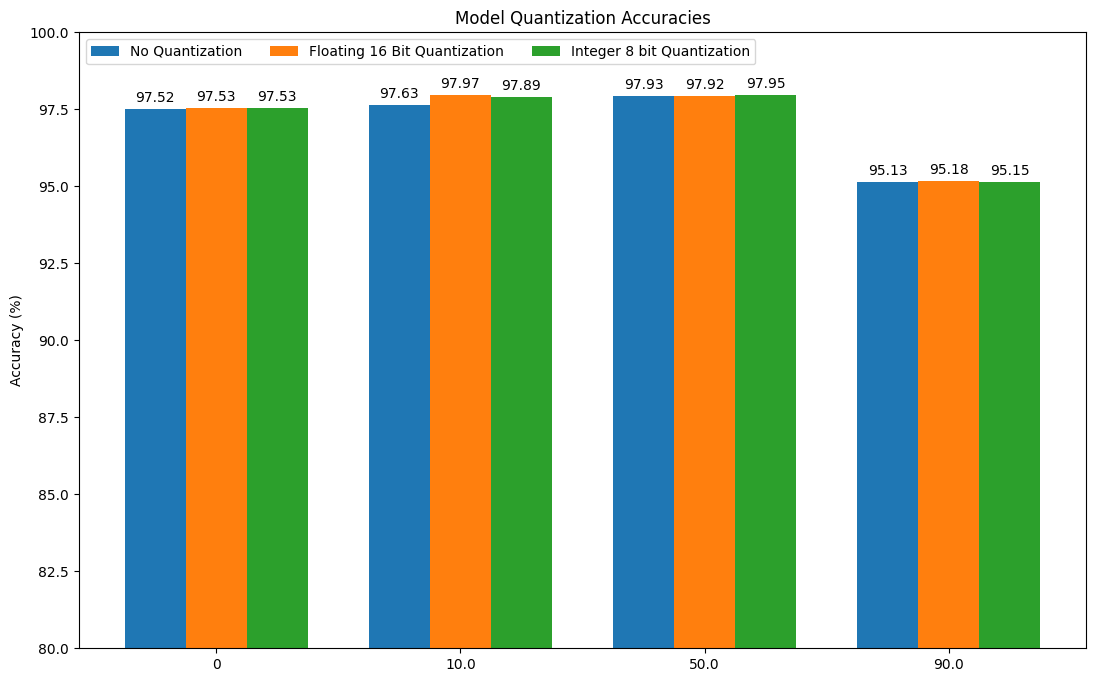

In [26]:
"""Accuracy"""
sparsitys = [sparsity*100 for sparsity in sparsities]
percent_accuracies = np.array(accuracies)*100

data = {
    'No Quantization': percent_accuracies[0::3],
    'Floating 16 Bit Quantization': percent_accuracies[1::3],
    'Integer 8 bit Quantization': percent_accuracies[2::3],
}

x = np.arange(len(sparsitys))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize = (13, 8))

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Quantization Accuracies')
ax.set_xticks(x + width, sparsitys)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(80, 100)

plt.show()

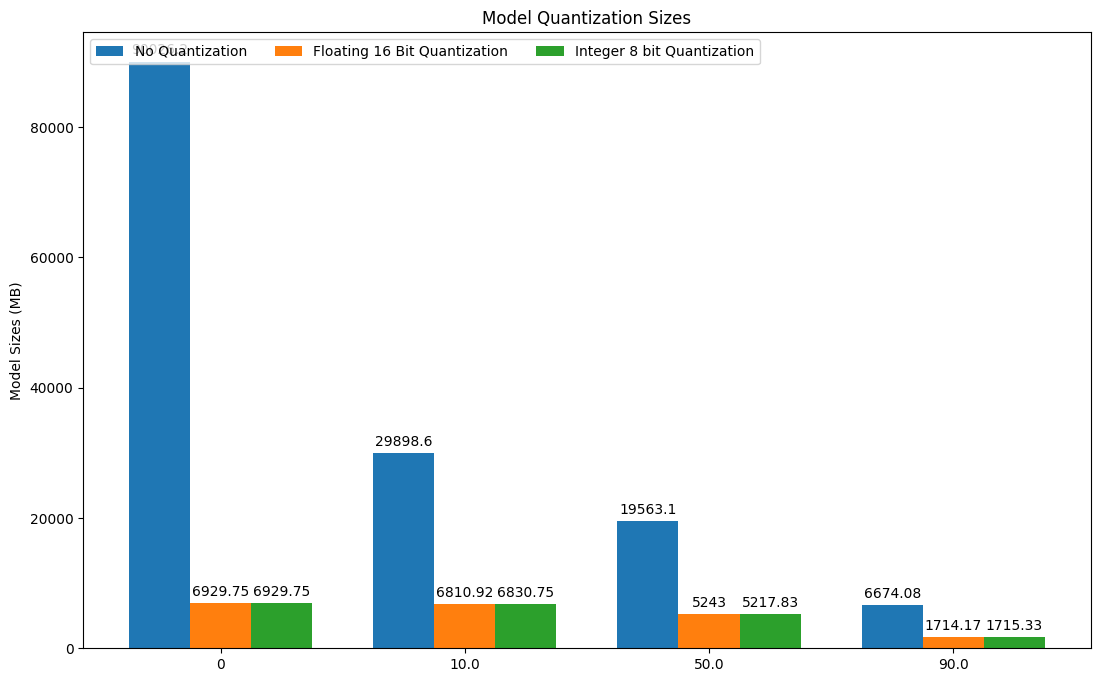

In [28]:
"""Model Size"""
sparsitys = [sparsity*100 for sparsity in sparsities]
model_sizes_new = np.array(model_sizes)/(10^6)

data = {
    'No Quantization': model_sizes_new[0::3],
    'Floating 16 Bit Quantization': model_sizes_new[1::3],
    'Integer 8 bit Quantization': model_sizes_new[2::3],
}

x = np.arange(len(sparsitys))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize = (13, 8))

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model Sizes (MB)')
ax.set_title('Model Quantization Sizes')
ax.set_xticks(x + width, sparsitys)
ax.legend(loc='upper left', ncols=3)

plt.show()

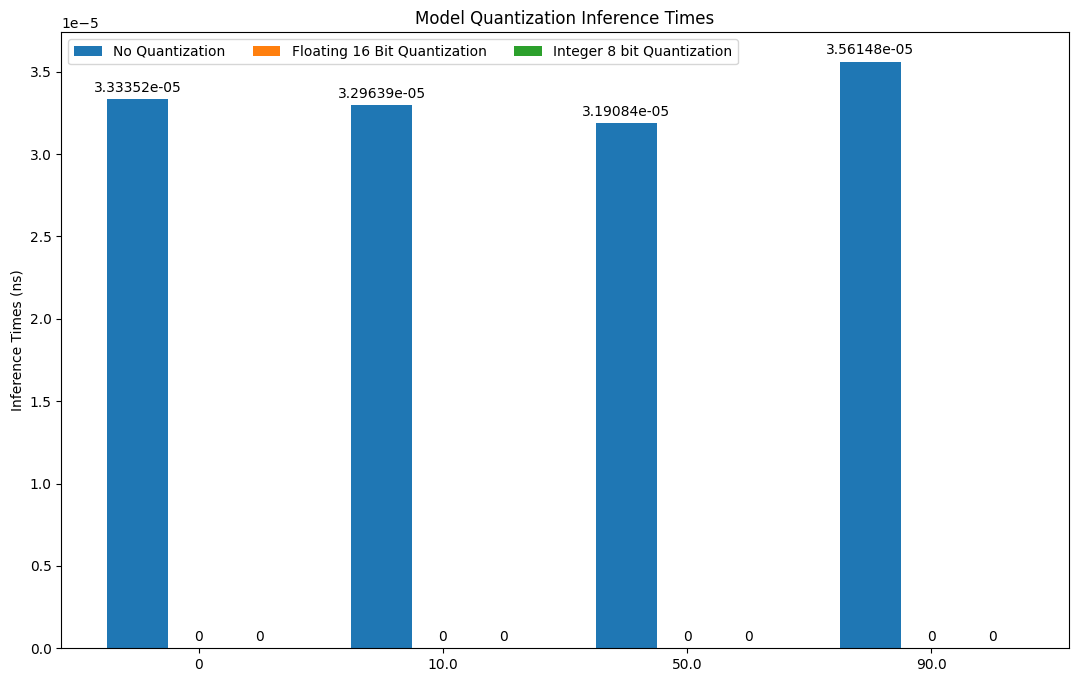

In [30]:
"""Inference Times"""
sparsitys = [sparsity*100 for sparsity in sparsities]
inference_times_new = np.array(inference_times)/(10^9)

data = {
    'No Quantization': inference_times_new[0::3],
    'Floating 16 Bit Quantization': inference_times_new[1::3],
    'Integer 8 bit Quantization': inference_times_new[2::3],
}

x = np.arange(len(sparsitys))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize = (13, 8))

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Inference Times (ns)')
ax.set_title('Model Quantization Inference Times')
ax.set_xticks(x + width, sparsitys)
ax.legend(loc='upper left', ncols=3)

plt.show()

Question-2 (1 point) Redo question 1 above (using the funnction that you wrote) but this time using the CNN model that you proposed in Lab-1 Q4 as the base model. Discuss the trade-offs obtained between accuracy and model size as a function of pruning level and quantization. This time, also plot the histrogram of weights (a particular layer or all over them combined) for at least 2 different pruning levels (sample code for this is shown under visualize pruning. Does the histogram of pruned weights give any insights on the accuracy observed?

In [33]:
sparsities = [0,0.10,0.50,0.90]
quantizations = [0, 16, 8]

accuracies = list()
model_sizes = list()
inference_times = list()

do_prune = True
do_quantize = True
fp16=True

train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

for sparsity in sparsities:
    if sparsity == 0:
        do_prune = False
        
    for quantization in quantizations:
        if quantization == 0:
            do_quantize = False
        elif quantization == 16:
            fp16 = True
        else:
            fp16 = False

        accuracy, model_size, inference_time = prune_and_quantize(
            model="lab_1_q4.h5",
            target_sparsity=sparsity,
            prun=do_prune,
            quantiz=do_quantize,
        )
        accuracies.append(accuracy)
        model_sizes.append(model_size)
        inference_times.append(inference_time) 
        do_quantize = True
    do_prune = True

print(f"{accuracies=}")
print(f"{model_sizes=}")
print(f"{inference_times=}")

c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 [==============================] - 1s 3ms/step
INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp21a1o11u\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp21a1o11u\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmpgc9msedv\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmpgc9msedv\assets


Epoch 1/2


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 13s 5ms/step - loss: 0.0854 - accuracy: 0.9734 - val_loss: 0.0701 - val_accuracy: 0.9800
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0792 - accuracy: 0.9754 - val_loss: 0.0798 - val_accuracy: 0.9763


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 3ms/step
Epoch 1/2
1688/1688 [==============================] - 12s 5ms/step - loss: 0.0860 - accuracy: 0.9733 - val_loss: 0.0819 - val_accuracy: 0.9768
Epoch 2/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0802 - accuracy: 0.9748 - val_loss: 0.0652 - val_accuracy: 0.9827


313/313 [==============================] - 1s 3ms/step


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp9vq1b8pp\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp9vq1b8pp\assets


Epoch 1/2


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 12s 5ms/step - loss: 0.0845 - accuracy: 0.9734 - val_loss: 0.0680 - val_accuracy: 0.9792
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0799 - accuracy: 0.9752 - val_loss: 0.0626 - val_accuracy: 0.9832


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 3ms/step


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmpq8faferg\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmpq8faferg\assets


Epoch 1/2


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 12s 5ms/step - loss: 0.1009 - accuracy: 0.9694 - val_loss: 0.0755 - val_accuracy: 0.9785
Epoch 2/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0827 - accuracy: 0.9736 - val_loss: 0.0710 - val_accuracy: 0.9798


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 2ms/step
Epoch 1/2
1688/1688 [==============================] - 14s 6ms/step - loss: 0.1004 - accuracy: 0.9691 - val_loss: 0.0690 - val_accuracy: 0.9793
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0821 - accuracy: 0.9739 - val_loss: 0.0862 - val_accuracy: 0.9733


313/313 [==============================] - 1s 2ms/step


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmpcjkwxiw9\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmpcjkwxiw9\assets


Epoch 1/2


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 11s 5ms/step - loss: 0.1011 - accuracy: 0.9694 - val_loss: 0.0805 - val_accuracy: 0.9768
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0826 - accuracy: 0.9738 - val_loss: 0.0692 - val_accuracy: 0.9803


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 2s 4ms/step


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp7jq36t3z\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp7jq36t3z\assets


Epoch 1/2


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 11s 5ms/step - loss: 1.0322 - accuracy: 0.6913 - val_loss: 0.4403 - val_accuracy: 0.8710
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.4106 - accuracy: 0.8728 - val_loss: 0.3079 - val_accuracy: 0.9090


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 3ms/step
Epoch 1/2
1688/1688 [==============================] - 12s 5ms/step - loss: 0.9767 - accuracy: 0.7177 - val_loss: 0.3916 - val_accuracy: 0.8847
Epoch 2/2
1688/1688 [==============================] - 9s 5ms/step - loss: 0.3778 - accuracy: 0.8843 - val_loss: 0.2862 - val_accuracy: 0.9157


313/313 [==============================] - 1s 2ms/step


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmpw0t66vue\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmpw0t66vue\assets


Epoch 1/2


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 12s 5ms/step - loss: 0.9943 - accuracy: 0.7109 - val_loss: 0.4097 - val_accuracy: 0.8817
Epoch 2/2
1688/1688 [==============================] - 8s 5ms/step - loss: 0.3940 - accuracy: 0.8805 - val_loss: 0.3012 - val_accuracy: 0.9122


c:\Users\johns\Documents\EngineeringRepositories\ENDG511\lab-env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 2ms/step


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp46w1gn_9\assets


INFO:tensorflow:Assets written to: C:\Users\johns\AppData\Local\Temp\tmp46w1gn_9\assets


accuracies=[0.9708999991416931, 0.9714, 0.9714, 0.9728000164031982, 0.9788, 0.9788, 0.9768000245094299, 0.969, 0.9774, 0.9010999798774719, 0.9083, 0.9046]
model_sizes=[147209, 17296, 17296, 48386, 16864, 16889, 32888, 12962, 12959, 13659, 6051, 6034]
inference_times=[0.00013111393451690673, 0.0, 0.0, 0.00013463714122772218, 0.0, 0.0, 0.00011077070236206055, 0.0, 0.0, 0.00012650465965270997, 0.0, 0.0]


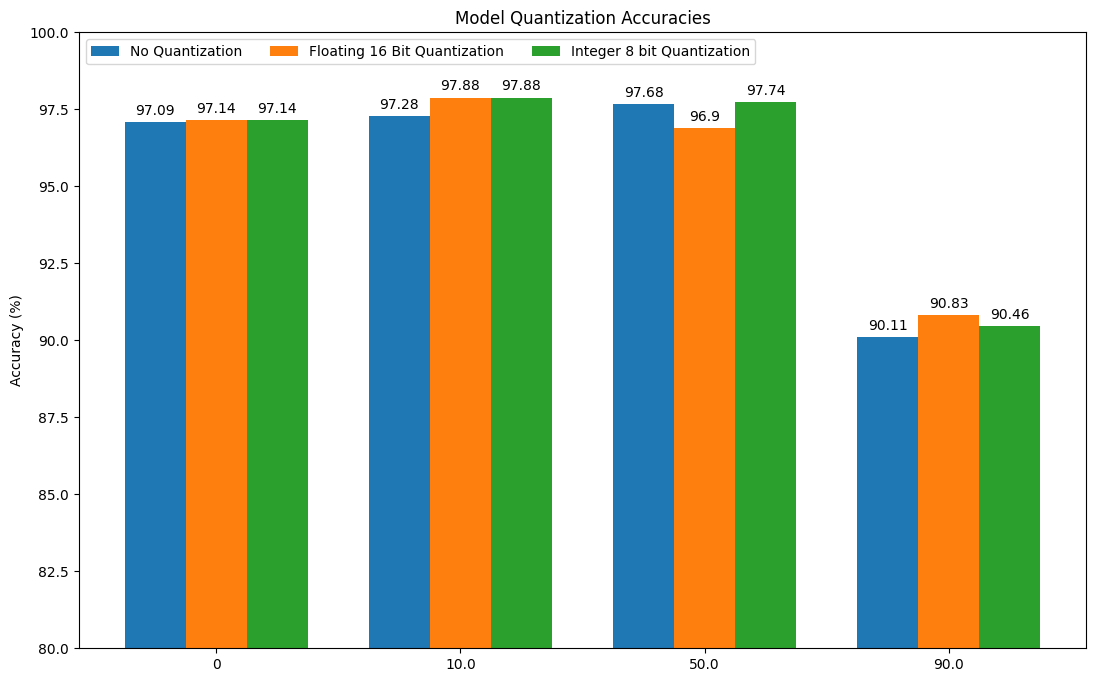

In [34]:
"""Accuracy"""
sparsitys = [sparsity*100 for sparsity in sparsities]
percent_accuracies = np.array(accuracies)*100

data = {
    'No Quantization': percent_accuracies[0::3],
    'Floating 16 Bit Quantization': percent_accuracies[1::3],
    'Integer 8 bit Quantization': percent_accuracies[2::3],
}

x = np.arange(len(sparsitys))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize = (13, 8))

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Quantization Accuracies')
ax.set_xticks(x + width, sparsitys)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(80, 100)

plt.show()

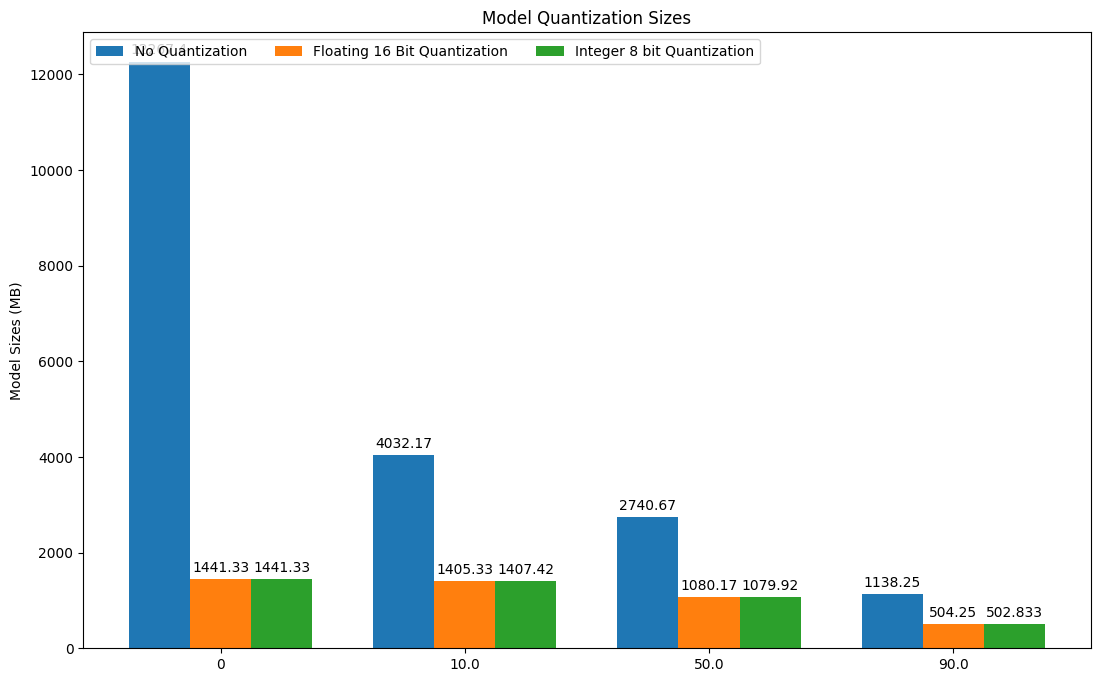

In [35]:
"""Model Size"""
sparsitys = [sparsity*100 for sparsity in sparsities]
model_sizes_new = np.array(model_sizes)/(10^6)

data = {
    'No Quantization': model_sizes_new[0::3],
    'Floating 16 Bit Quantization': model_sizes_new[1::3],
    'Integer 8 bit Quantization': model_sizes_new[2::3],
}

x = np.arange(len(sparsitys))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize = (13, 8))

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model Sizes (MB)')
ax.set_title('Model Quantization Sizes')
ax.set_xticks(x + width, sparsitys)
ax.legend(loc='upper left', ncols=3)

plt.show()

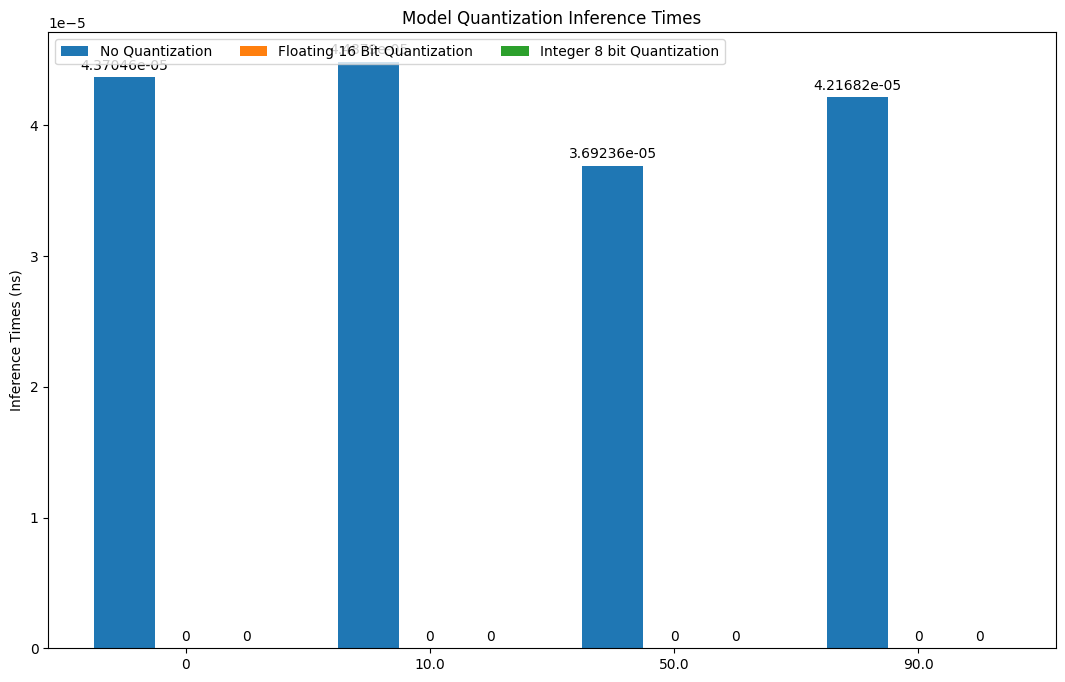

In [36]:
"""Inference Times"""
sparsitys = [sparsity*100 for sparsity in sparsities]
inference_times_new = np.array(inference_times)/(10^9)

data = {
    'No Quantization': inference_times_new[0::3],
    'Floating 16 Bit Quantization': inference_times_new[1::3],
    'Integer 8 bit Quantization': inference_times_new[2::3],
}

x = np.arange(len(sparsitys))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize = (13, 8))

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Inference Times (ns)')
ax.set_title('Model Quantization Inference Times')
ax.set_xticks(x + width, sparsitys)
ax.legend(loc='upper left', ncols=3)

plt.show()

# Optional: Visualize Pruning
In this section we will graph a small subset of the weights at different levels of pruning. The graphs clearly show how different sparsity levels affect the number of zero weights, it also shows that our pruning is unstructured.

We also provide histograms of the weights before and after pruning.

Note: Make sure you have saved the tflite files with the same names used below, alternatively you can change the model path with your correct file name. The first visualization relies on files collected from the exercise in PART 3!

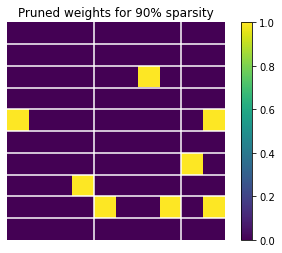

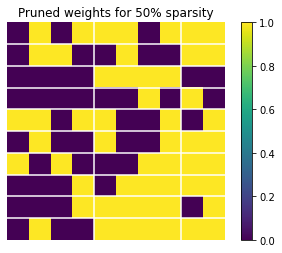

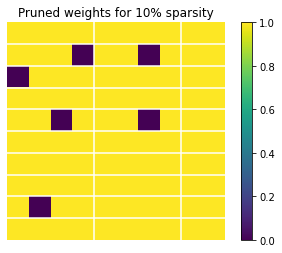

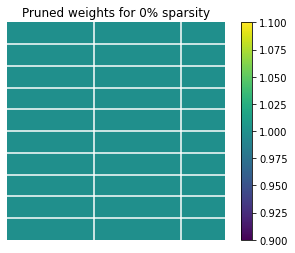

In [ ]:
def get_tensor_data(model_path):
  # Load tflite file with the created pruned model
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  details = interpreter.get_tensor_details()

  # Weights of the dense layer that has been pruned.
  tensor_name = 'sequential/dense_1/MatMul'
  detail = [x for x in details if tensor_name in x["name"]]

  # We need the first layer.
  tensor_data = interpreter.tensor(detail[0]["index"])()
  return tensor_data

# The value 10 is chosen for convenience.
width = height = 10


def plot_separation_lines(height, width):

    block_size = [1, 4]

    # Add separation lines to the figure.
    num_hlines = int((height - 1) / block_size[0])
    num_vlines = int((width - 1) / block_size[1])
    line_y_pos = [y * block_size[0] for y in range(1, num_hlines + 1)]
    line_x_pos = [x * block_size[1] for x in range(1, num_vlines + 1)]

    for y_pos in line_y_pos:
        plt.plot([-0.5, width], [y_pos - 0.5 , y_pos - 0.5], color='w')

    for x_pos in line_x_pos:
        plt.plot([x_pos - 0.5, x_pos - 0.5], [-0.5, height], color='w')

def plot_weights_graph(tensor_data, sparsity):
  weights_to_display = tf.reshape(tensor_data, [tensor_data.shape[0],tf.reduce_prod(tensor_data.shape[1:])])
  weights_to_display = weights_to_display[0:width, 0:height]

  val_ones = np.ones([height, width])
  val_zeros = np.zeros([height, width])
  subset_values_to_display = np.where(abs(weights_to_display) > 0, val_ones, val_zeros)

  plot_separation_lines(height, width)

  plt.axis('off')
  plt.imshow(subset_values_to_display)
  plt.colorbar()
  plt.title("Pruned weights for {0}% sparsity".format(sparsity))
  plt.show()

## USE YOUR MODEL PATH
plot_weights_graph(get_tensor_data('pruned_0.9_fp16_quantized_tflite_model.tflite'), 90)
plot_weights_graph(get_tensor_data('pruned_0.5_fp16_quantized_tflite_model.tflite'), 50)
plot_weights_graph(get_tensor_data('pruned_0.1_fp16_quantized_tflite_model.tflite'), 10)
plot_weights_graph(get_tensor_data('pruned_0_fp16_quantized_tflite_model.tflite'), 0)

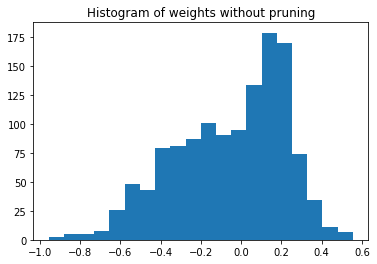

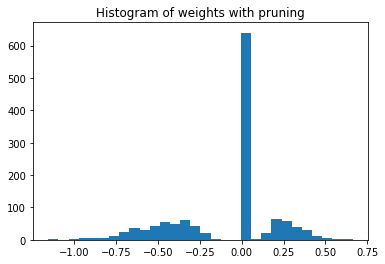

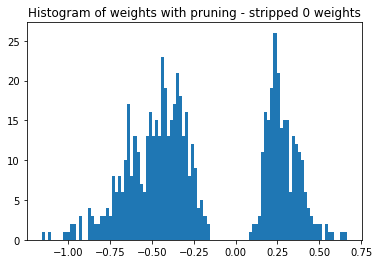

In [ ]:
## Plotting Pruning Histograms
model = tf.keras.models.load_model('trained_base_model.h5')
a = model.layers[3].weights
b = pruned_model.layers[3].weights

k = a[0].numpy().flatten()
plt.hist(k, bins = 100)
plt.title("Histogram of weights without pruning")
plt.show()

j = b[0].numpy().flatten()
plt.hist(j, bins = 100)
plt.title("Histogram of weights with pruning")
plt.show()

l = j[j != 0]
plt.hist(l, bins = 100)
plt.title("Histogram of weights with pruning - stripped 0 weights")
plt.show()